# Práctica 4: Tarea de regresión

In [52]:
%%capture
!pip install spacy
!pip install nltk
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install folium
!pip install xgboost

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from IPython.display import display, IFrame
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display, IFrame
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Analisis exploratorio

In [3]:
df = pd.read_csv('train_airlines_delay_challenge.csv')
#df_test = pd.read_csv('test_housing_data_italy.csv')
df.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,2009-09-05,AA,2062,MIA,BOS,1055.0,1139.0,44.0,15.0,1154.0,1405.0,30.0,190.0,1258.0
1,2009-05-08,XE,2926,IAH,ELP,2115.0,2112.0,-3.0,17.0,2129.0,2219.0,-15.0,124.0,667.0
2,2009-03-16,OH,6433,CVG,DSM,1430.0,1425.0,-5.0,25.0,1450.0,1518.0,7.0,108.0,505.0
3,2009-03-04,OO,5439,LAX,SBA,820.0,814.0,-6.0,15.0,829.0,905.0,-11.0,45.0,89.0
4,2009-06-12,WN,615,LAS,MCI,1235.0,1234.0,-1.0,13.0,1247.0,1735.0,-26.0,180.0,1140.0


Columnas principales:

- Aerolinea (OP_CARRIER).
- Fecha del vuelo (FL_DATE).
- Numero de vuelo (OP_CARRIER_FL_NUM).
- Origen y destino (ORIGIN, DEST).
- Hora de partida, aterrizaje, y tiempo de vuelo planeadas (CRS_DEP_TIME, CRS_ARR_TIME, CRS_ELAPSED_TIME)
- Distancia del vuelo (DISTANCE)
- Horas de salida reales (DEP_TIME,TAXI_OUT,WHEELS_OFF)
- retrasos reales (DEP_DELAY,ARR_DELAY)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000000 entries, 0 to 8999999
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   OP_CARRIER_FL_NUM  int64  
 3   ORIGIN             object 
 4   DEST               object 
 5   CRS_DEP_TIME       float64
 6   DEP_TIME           float64
 7   DEP_DELAY          float64
 8   TAXI_OUT           float64
 9   WHEELS_OFF         float64
 10  CRS_ARR_TIME       float64
 11  ARR_DELAY          float64
 12  CRS_ELAPSED_TIME   float64
 13  DISTANCE           float64
dtypes: float64(9), int64(1), object(4)
memory usage: 961.3+ MB


Revisamos la cantidad de nulos

In [5]:
missing_data = df.isnull().sum()
print(missing_data)

FL_DATE              0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
CRS_DEP_TIME         0
DEP_TIME             0
DEP_DELAY            0
TAXI_OUT             0
WHEELS_OFF           0
CRS_ARR_TIME         0
ARR_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64


Revisamos las estadisticas de nuestras variables numericas

In [6]:
statistics = df[['OP_CARRIER_FL_NUM','CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'CRS_ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE']].describe()
print(statistics)

       OP_CARRIER_FL_NUM  CRS_DEP_TIME      DEP_TIME     DEP_DELAY  \
count       9.000000e+06  9.000000e+06  9.000000e+06  9.000000e+06   
mean        2.245577e+03  1.326138e+03  1.332794e+03  8.889274e+00   
std         1.877307e+03  4.730146e+02  4.856179e+02  3.604610e+01   
min         1.000000e+00  1.000000e+00  1.000000e+00 -2.340000e+02   
25%         6.970000e+02  9.230000e+02  9.250000e+02 -5.000000e+00   
50%         1.684000e+03  1.320000e+03  1.327000e+03 -2.000000e+00   
75%         3.467000e+03  1.725000e+03  1.733000e+03  7.000000e+00   
max         9.320000e+03  2.359000e+03  2.400000e+03  1.805000e+03   

           TAXI_OUT    WHEELS_OFF  CRS_ARR_TIME     ARR_DELAY  \
count  9.000000e+06  9.000000e+06  9.000000e+06  9.000000e+06   
mean   1.581331e+01  1.355605e+03  1.495601e+03  4.658041e+00   
std    9.185871e+00  4.869539e+02  4.932537e+02  3.852880e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00 -2.380000e+02   
25%    1.000000e+01  9.390000e+02  1.115000e

Revisamos variables categoricas

In [7]:
unique_values1 = df['OP_CARRIER'].unique()
unique_values2 = df['ORIGIN'].unique()
unique_values3 = df['DEST'].unique()


print(unique_values1, unique_values2, unique_values3)

['AA' 'XE' 'OH' 'OO' 'WN' 'EV' 'YV' 'NW' 'UA' 'MQ' 'F9' 'US' 'FL' 'CO'
 'AS' 'DL' 'B6' 'HA' '9E' 'VX' 'NK'] ['MIA' 'IAH' 'CVG' 'LAX' 'LAS' 'OAK' 'FAY' 'RSW' 'LGA' 'DTW' 'JFK' 'SFO'
 'ORD' 'MCI' 'EWR' 'PBI' 'CLT' 'PHL' 'SEA' 'BIL' 'SLC' 'OMA' 'DFW' 'RDU'
 'DEN' 'GRR' 'CLE' 'AUS' 'ATL' 'MKE' 'SAN' 'DCA' 'RIC' 'BUF' 'SJC' 'LCH'
 'BOS' 'CMI' 'TUS' 'MDW' 'CID' 'BIS' 'MSP' 'MEM' 'FNT' 'TPA' 'CHS' 'ORF'
 'SJU' 'FLL' 'JAX' 'DSM' 'PHX' 'BWI' 'BOI' 'HSV' 'IAD' 'MSY' 'GEG' 'CWA'
 'LRD' 'TUL' 'SMF' 'STL' 'HOU' 'TLH' 'LEX' 'CRP' 'MCO' 'BNA' 'JNU' 'CLL'
 'ELP' 'EGE' 'MSN' 'RKS' 'ROC' 'ICT' 'HNL' 'TRI' 'PHF' 'ROW' 'PVD' 'SNA'
 'TYS' 'DAB' 'EUG' 'ABQ' 'LGB' 'ABI' 'XNA' 'DAL' 'RNO' 'BTV' 'SBA' 'CMH'
 'PIT' 'IND' 'BHM' 'FAI' 'DLH' 'SAT' 'FSD' 'ITO' 'SGF' 'OGG' 'JAN' 'CPR'
 'HPN' 'BUR' 'PFN' 'MHT' 'DRO' 'SAV' 'MDT' 'AMA' 'ELM' 'ANC' 'PSP' 'RDM'
 'MLU' 'EYW' 'OKC' 'GUC' 'DAY' 'ONT' 'STT' 'LIT' 'PDX' 'LMT' 'ASE' 'ISP'
 'MFR' 'LBB' 'MBS' 'ALB' 'SYR' 'LIH' 'BFL' 'EVV' 'MGM' 'GRB' 'WRG' 'BDL'
 'CAK' 'PSC' 'GJ

# Limpieza de datos

Primero nos deshacemos de la mayoria de nulos.

Los datos ya estan limpios en su mayoria asi que los dejare asi, me concentre en la generacion de caracteristicas

In [8]:
# 1. Dia de la semana
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# 2. Mes
df['MONTH'] = df['FL_DATE'].dt.month

# 3. Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df['FL_DATE'].min(), end=df['FL_DATE'].max())
df['IS_HOLIDAY'] = df['FL_DATE'].isin(holidays).astype(int)

# 4. Horas pico
# De acuerdo con sitios web estas sueren  ser las horas pico en aeropuertos 
def is_peak_hour(dep_time):
    hour = int(dep_time // 100)
    return 1 if (6 <= hour <= 10) or (16 <= hour <= 20) else 0

df['PEAK_HOUR'] = df['CRS_DEP_TIME'].apply(is_peak_hour)

# 5. Retrasos historicos por numero de vuelo
avg_delay = df.groupby('OP_CARRIER_FL_NUM')['ARR_DELAY'].mean().reset_index()
avg_delay.columns = ['OP_CARRIER_FL_NUM', 'AVG_FLIGHT_DELAY']
df = df.merge(avg_delay, on='OP_CARRIER_FL_NUM', how='left')

# 6. Retraso del vuelo anterior
df = df.sort_values(by=['OP_CARRIER_FL_NUM', 'FL_DATE'])
df['PREV_FLIGHT_DELAY'] = df.groupby('OP_CARRIER_FL_NUM')['ARR_DELAY'].shift(1).fillna(0)

# 7. Grupos de distancia
distance_bins = [0, 300, 800, 1500, np.inf]
distance_labels = ['short_haul', 'medium_haul', 'long_haul', 'ultra_long_haul']
df['DISTANCE_BIN'] = pd.cut(df['DISTANCE'], bins=distance_bins, labels=distance_labels)

# 8. Delay promedio de la aerolinea
carrier_avg_delay = df.groupby('OP_CARRIER')['ARR_DELAY'].mean().reset_index()
carrier_avg_delay.columns = ['OP_CARRIER', 'CARRIER_AVG_DELAY']
df = df.merge(carrier_avg_delay, on='OP_CARRIER', how='left')

# 9. Destino y origen
df['ROUTE'] = df['ORIGIN'] + '-' + df['DEST']

# 10 Retraso categorico
def classify_arrival_status(arr_delay):
    if arr_delay < -15:
        return 'Early'
    elif arr_delay > 15:
        return 'Delay'
    else:
        return 'On Time'

df['ARRIVAL_STATUS'] = df['ARR_DELAY'].apply(classify_arrival_status)

# Hacemos Encode para facilitar comparacion
label_encoder = LabelEncoder()
df['ARRIVAL_STATUS_ENCODED'] = label_encoder.fit_transform(df['ARRIVAL_STATUS'])

ned_data = df

In [9]:

cleaned_data = ned_data
cleaned_data.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,...,MONTH,IS_HOLIDAY,PEAK_HOUR,AVG_FLIGHT_DELAY,PREV_FLIGHT_DELAY,DISTANCE_BIN,CARRIER_AVG_DELAY,ROUTE,ARRIVAL_STATUS,ARRIVAL_STATUS_ENCODED
0,2009-01-01,HA,1,LAX,HNL,845.0,841.0,-4.0,9.0,850.0,...,1,1,1,-0.084364,0.0,ultra_long_haul,0.753229,LAX-HNL,Early,1
1,2009-01-02,US,1,PHX,ORD,835.0,832.0,-3.0,15.0,847.0,...,1,0,1,-0.084364,-23.0,long_haul,1.943807,PHX-ORD,On Time,2
2,2009-01-03,HA,1,LAX,HNL,845.0,839.0,-6.0,20.0,859.0,...,1,0,1,-0.084364,-10.0,ultra_long_haul,0.753229,LAX-HNL,On Time,2
3,2009-01-03,UA,1,ORD,HNL,1014.0,1014.0,0.0,26.0,1040.0,...,1,0,1,-0.084364,-8.0,ultra_long_haul,3.008885,ORD-HNL,On Time,2
4,2009-01-04,UA,1,ORD,HNL,1014.0,1017.0,3.0,19.0,1036.0,...,1,0,1,-0.084364,-10.0,ultra_long_haul,3.008885,ORD-HNL,Early,1


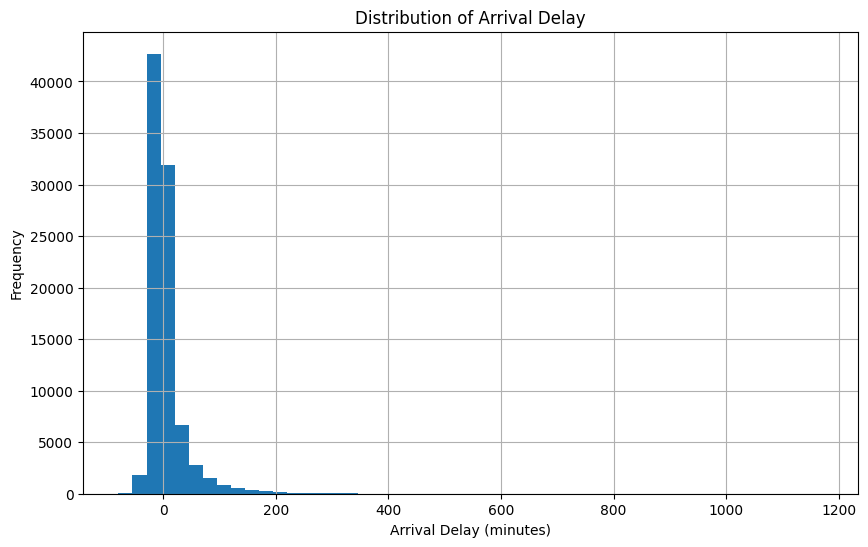

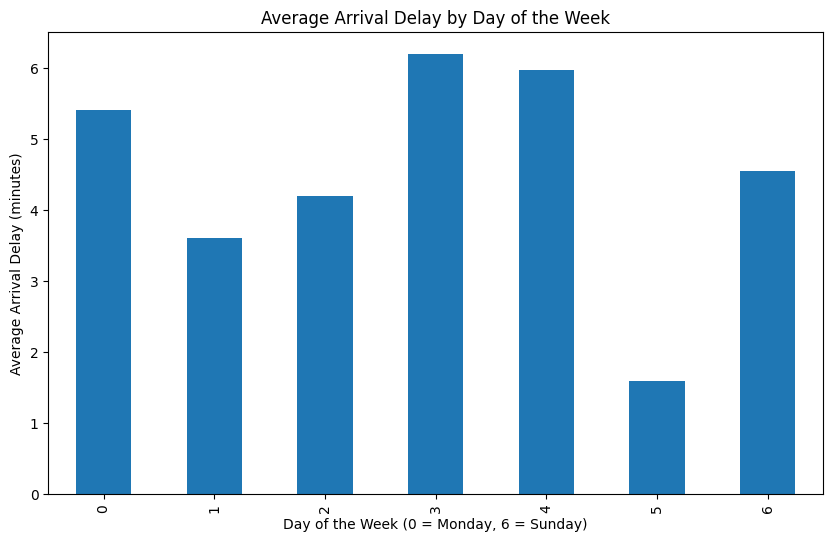

/var/folders/x1/xs2knmd10t5759tsv29bkcv00000gn/T/ipykernel_59058/1064458545.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_bin_avg = sample_df.groupby('DISTANCE_BIN')['ARR_DELAY'].mean()


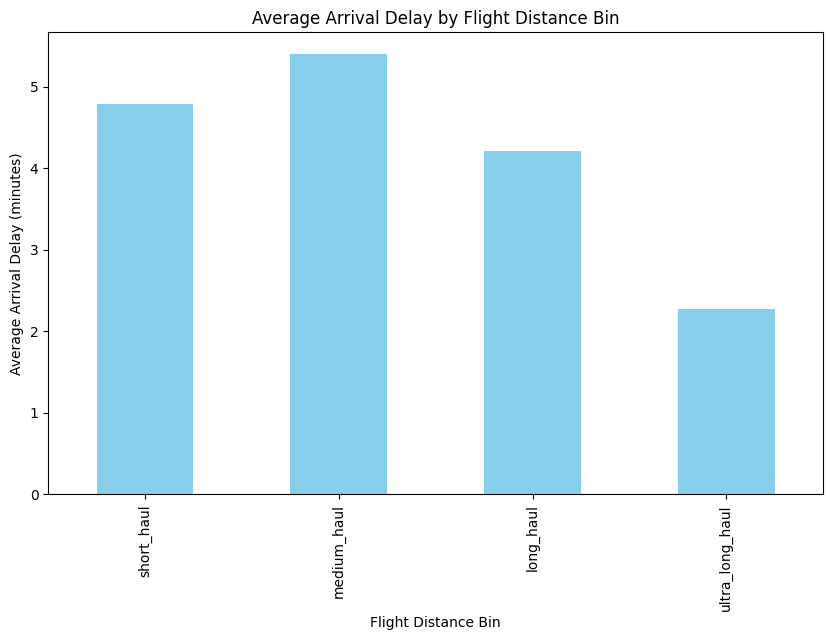

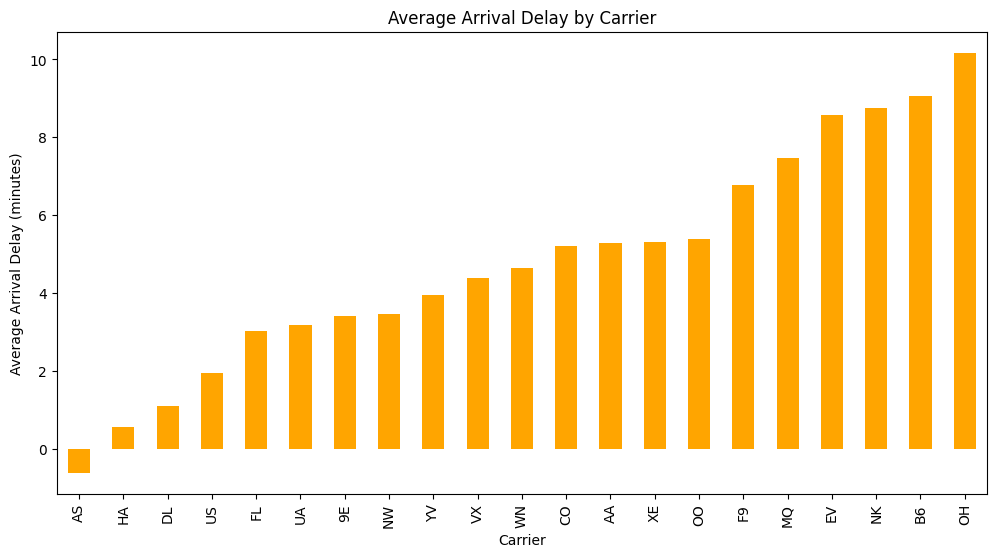

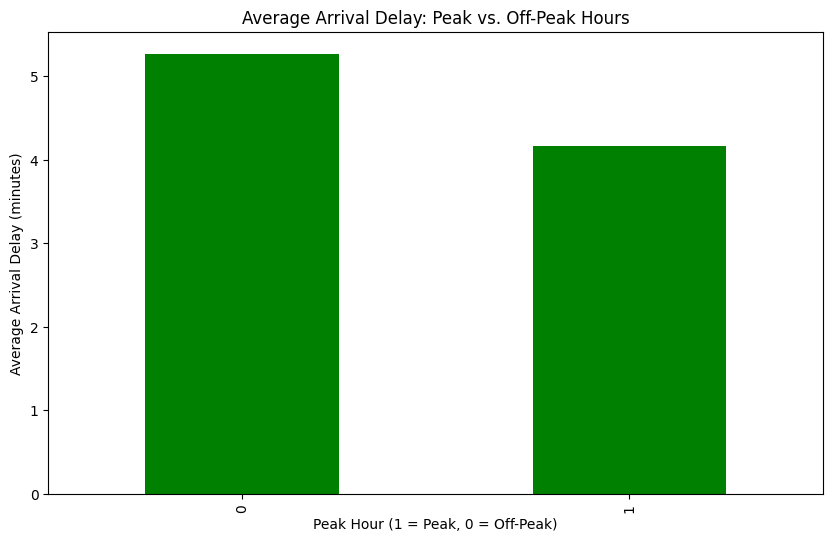

In [11]:
# Plotting graphs to analyze attributes
# 1. Distribution of ARR_DELAY
sample_df = df.sample(frac=0.01, random_state=42)  # Taking a 1% sample to avoid memory issues
plt.figure(figsize=(10, 6))
sample_df['ARR_DELAY'].hist(bins=50)
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Delay')
plt.show()

# 2. Average Delay by Day of the Week
plt.figure(figsize=(10, 6))
day_of_week_avg = sample_df.groupby('DAY_OF_WEEK')['ARR_DELAY'].mean()
day_of_week_avg.plot(kind='bar')
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Day of the Week')
plt.show()

# 3. Average Delay by Flight Distance Bin
plt.figure(figsize=(10, 6))
distance_bin_avg = sample_df.groupby('DISTANCE_BIN')['ARR_DELAY'].mean()
distance_bin_avg.plot(kind='bar', color='skyblue')
plt.xlabel('Flight Distance Bin')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Flight Distance Bin')
plt.show()

# 4. Average Delay by Carrier
plt.figure(figsize=(12, 6))
carrier_avg = sample_df.groupby('OP_CARRIER')['ARR_DELAY'].mean().sort_values()
carrier_avg.plot(kind='bar', color='orange')
plt.xlabel('Carrier')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay by Carrier')
plt.xticks(rotation=90)
plt.show()

# 5. Peak vs. Off-Peak Hours Effect on Arrival Delay
plt.figure(figsize=(10, 6))
peak_hour_avg = sample_df.groupby('PEAK_HOUR')['ARR_DELAY'].mean()
peak_hour_avg.plot(kind='bar', color='green')
plt.xlabel('Peak Hour (1 = Peak, 0 = Off-Peak)')
plt.ylabel('Average Arrival Delay (minutes)')
plt.title('Average Arrival Delay: Peak vs. Off-Peak Hours')
plt.show()

# Analisis exploratorio (continuacion)

Mapeamos los datos para ver la distribucion en un mapa

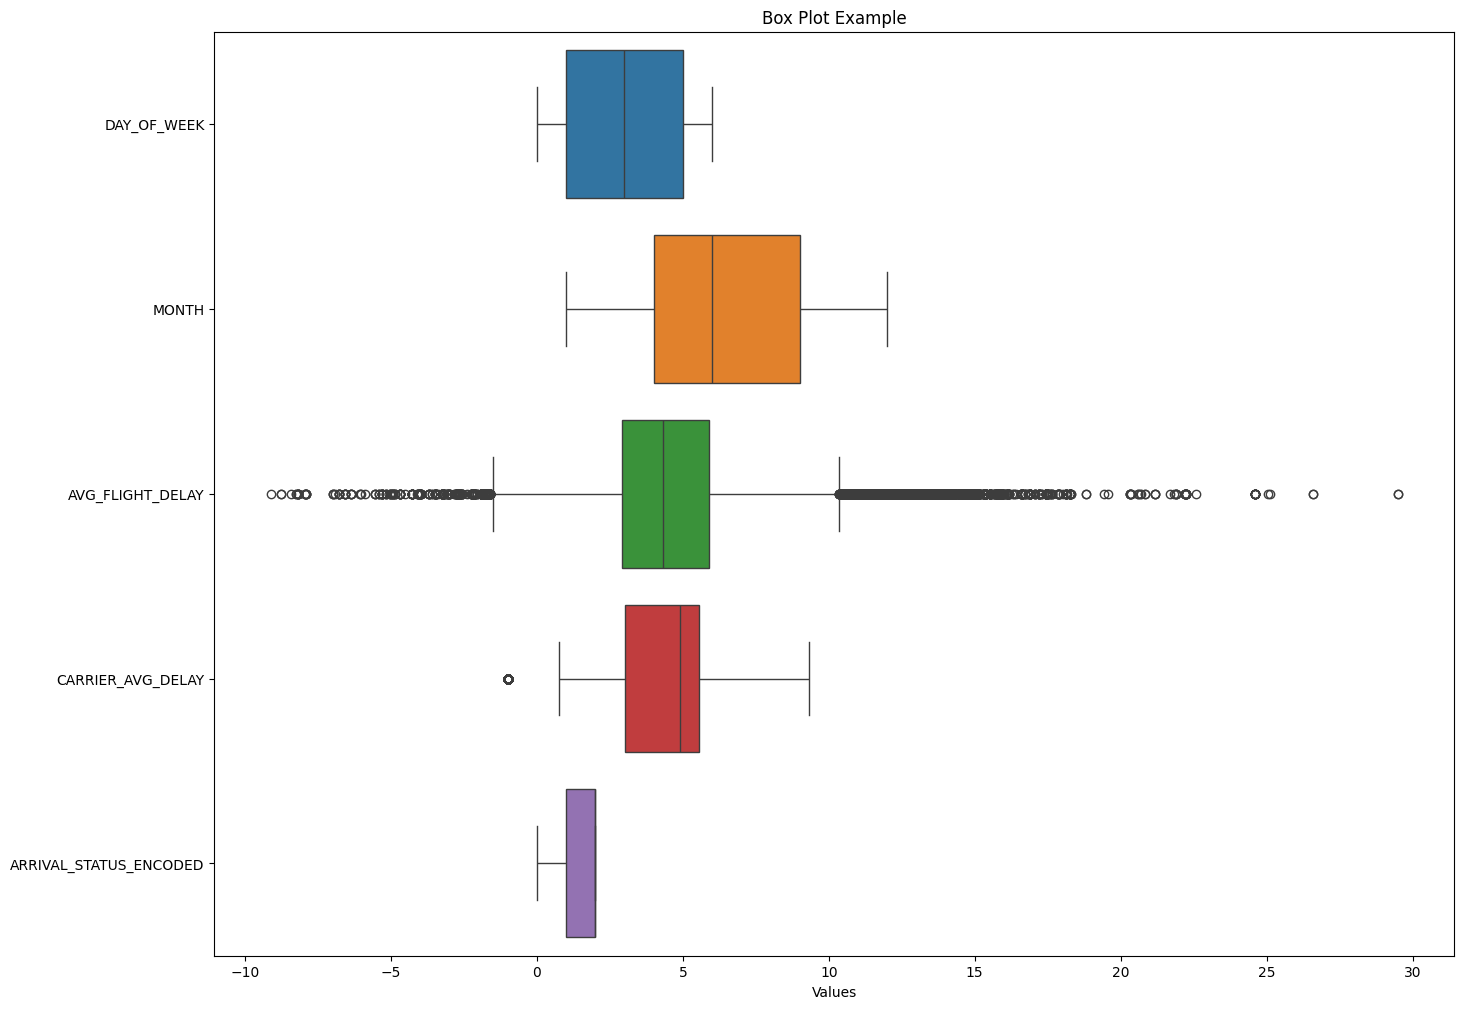

In [12]:
# Select numeric columns
data = sample_df.select_dtypes(include=[float, int])
data = data.drop(columns=['OP_CARRIER_FL_NUM', 'OP_CARRIER_FL_NUM', 'DISTANCE'])
data = data.drop(columns=['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF','CRS_ARR_TIME','PREV_FLIGHT_DELAY','DEP_DELAY','TAXI_OUT','ARR_DELAY','CRS_ELAPSED_TIME','PEAK_HOUR','IS_HOLIDAY'])
# Set figure size before creating the box plot
plt.figure(figsize=(16, 12))  # Adjust figure size for better visibility

# Create the box plot (horizontal)
sns.boxplot(data=data, orient='h')

# Add title and labels
plt.title('Box Plot Example')
plt.xlabel('Values')

# Display the plot
plt.show()

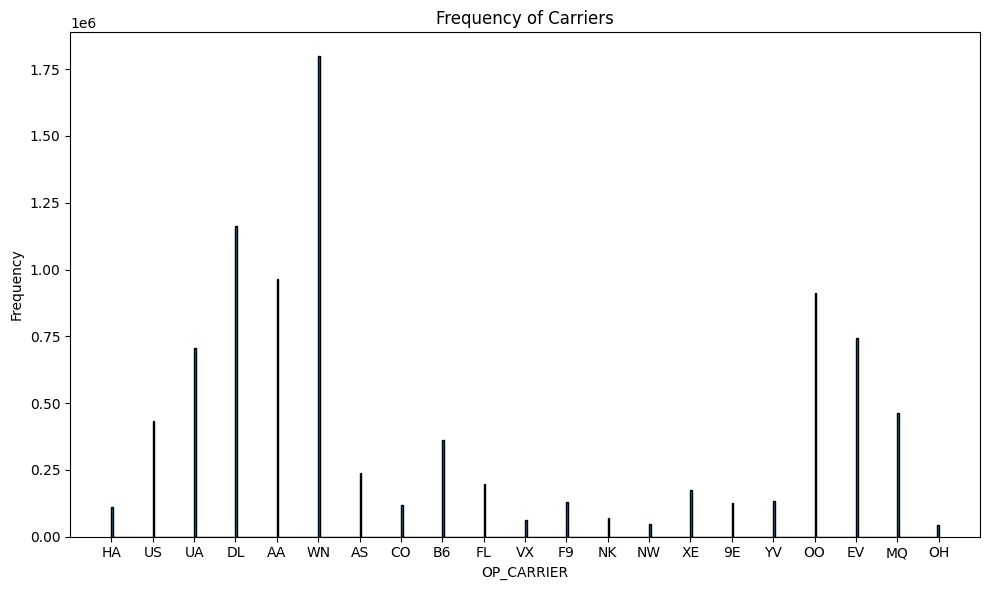

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_data['OP_CARRIER'], bins=500, edgecolor='black')
plt.xlabel('OP_CARRIER')
plt.ylabel('Frequency')
plt.title('Frequency of Carriers')
plt.tight_layout()
plt.show()


Se puede observar de manera general que a ma hay areas de concentracion donde las propiedades de alto valor se juntan

# Seleccion de caracteristicas

Primero creare una matriz de correlacion para ver que caracteristicas que podriamos usar para la seleccion.

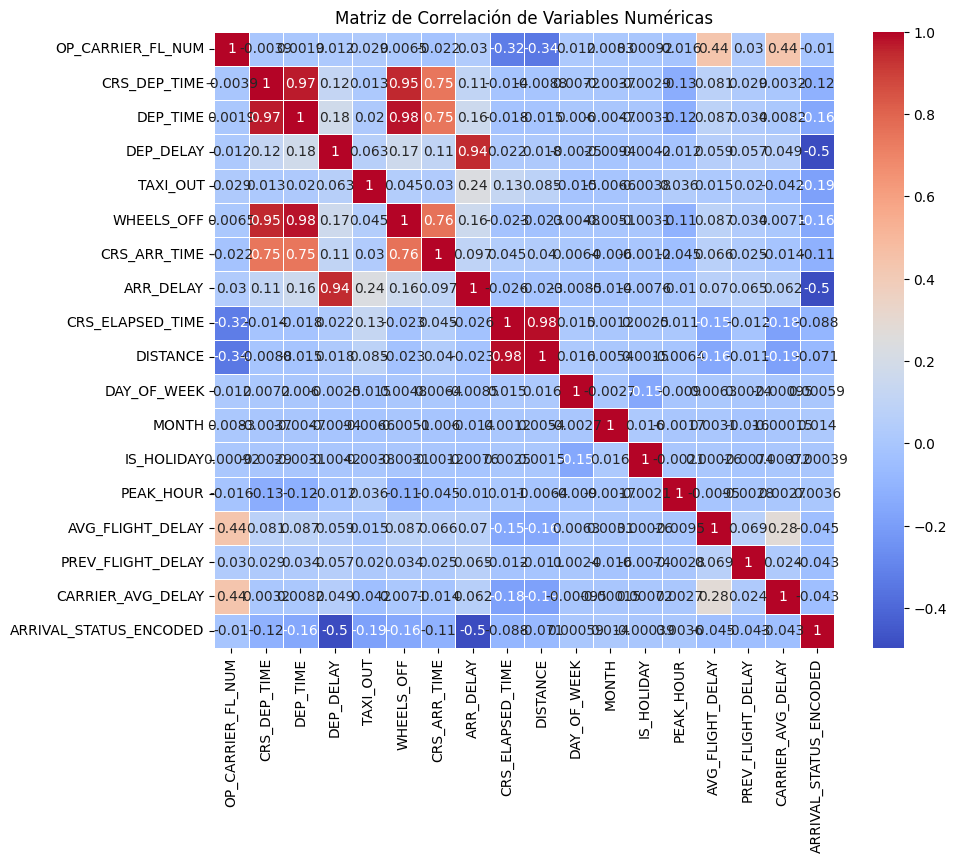

In [14]:

numeric_columns = cleaned_data.select_dtypes(include=[float, int])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

In [15]:
missing_data = cleaned_data.isnull().sum()
print(missing_data)
#missing_data = df_test.isnull().sum()
#print(missing_data)

FL_DATE                   0
OP_CARRIER                0
OP_CARRIER_FL_NUM         0
ORIGIN                    0
DEST                      0
CRS_DEP_TIME              0
DEP_TIME                  0
DEP_DELAY                 0
TAXI_OUT                  0
WHEELS_OFF                0
CRS_ARR_TIME              0
ARR_DELAY                 0
CRS_ELAPSED_TIME          0
DISTANCE                  0
DAY_OF_WEEK               0
MONTH                     0
IS_HOLIDAY                0
PEAK_HOUR                 0
AVG_FLIGHT_DELAY          0
PREV_FLIGHT_DELAY         0
DISTANCE_BIN              0
CARRIER_AVG_DELAY         0
ROUTE                     0
ARRIVAL_STATUS            0
ARRIVAL_STATUS_ENCODED    0
dtype: int64


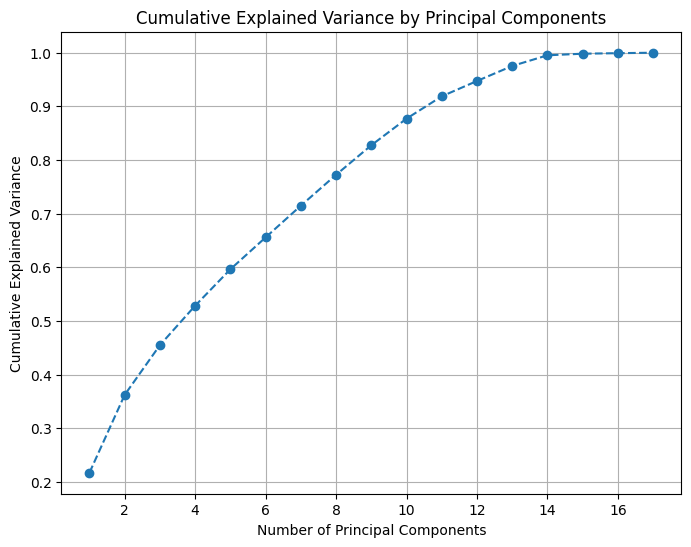

In [16]:

numeric_columns = cleaned_data.select_dtypes(include=[float, int]).drop(columns=['ARR_DELAY'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)

pca = PCA(n_components=len(numeric_columns.columns))
pca_result = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_.cumsum()

#Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


Chi-Squared Test Results:
         Feature           Chi2        p-value
8         ROUTE  401789.147841   0.000000e+00
2          DEST   42690.249851   0.000000e+00
1        ORIGIN   22924.236169   0.000000e+00
0    OP_CARRIER   13824.980285   0.000000e+00
4         MONTH    1750.037413   0.000000e+00
6     PEAK_HOUR    1178.452870  2.938508e-258
3   DAY_OF_WEEK    1173.814341  2.993820e-257
5    IS_HOLIDAY    1064.415813  1.790690e-233
7  DISTANCE_BIN     235.365274   4.030166e-53


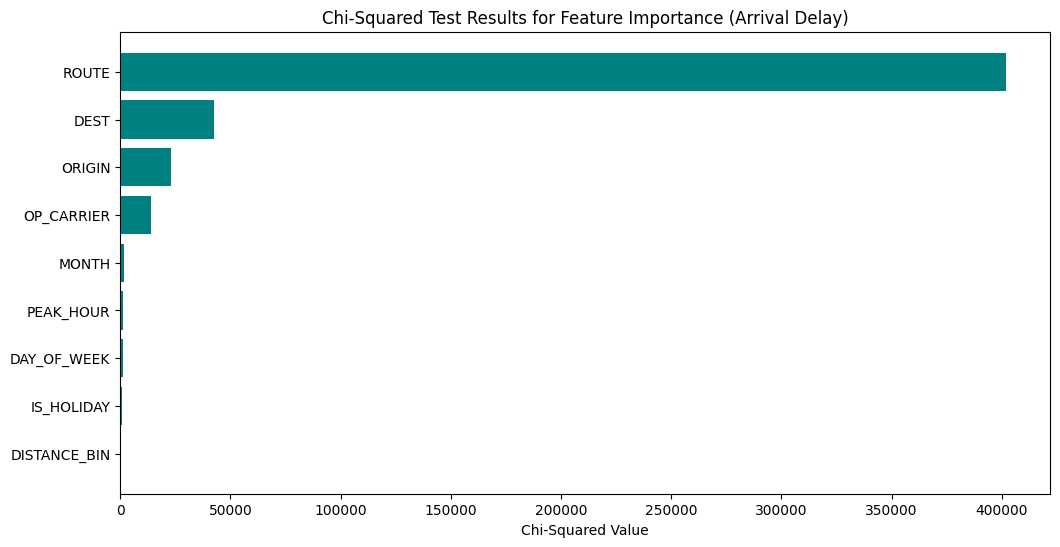

In [17]:
# Chi-Squared Test to Determine Feature Importance
# Selecting relevant categorical features and encoding them
categorical_features = ['OP_CARRIER', 'ORIGIN', 'DEST', 'DAY_OF_WEEK', 'MONTH', 'IS_HOLIDAY', 'PEAK_HOUR', 'DISTANCE_BIN', 'ROUTE']
encoded_df = cleaned_data.copy()

# Encoding categorical features
label_encoder = LabelEncoder()
for feature in categorical_features:
    encoded_df[feature] = label_encoder.fit_transform(encoded_df[feature].astype(str))

# Selecting features and target
X = encoded_df[categorical_features]
y = (encoded_df['ARR_DELAY'] > 0).astype(int)  # Binary target: 1 if ARR_DELAY > 0, else 0

# Chi-squared test
chi2_values, p_values = chi2(X, y)
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_values, 'p-value': p_values})
chi2_df = chi2_df.sort_values(by='Chi2', ascending=False)

print("Chi-Squared Test Results:\n", chi2_df)

# Plotting Chi-Squared values for features
plt.figure(figsize=(12, 6))
plt.barh(chi2_df['Feature'], chi2_df['Chi2'], color='teal')
plt.xlabel('Chi-Squared Value')
plt.title('Chi-Squared Test Results for Feature Importance (Arrival Delay)')
plt.gca().invert_yaxis()
plt.show()


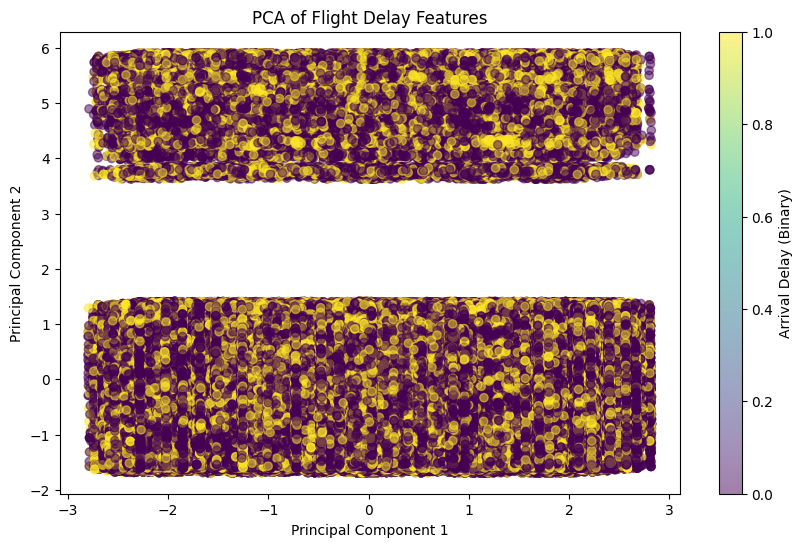

Explained Variance Ratio by Principal Components: [0.22460558 0.12994196]

Principal Component Loadings:
                   PC1       PC2
OP_CARRIER    0.142796  0.026783
ORIGIN        0.698527 -0.000596
DEST          0.050879  0.001309
DAY_OF_WEEK   0.004333 -0.637610
MONTH        -0.001992 -0.294949
IS_HOLIDAY    0.000261  0.709996
PEAK_HOUR    -0.005432  0.027409
DISTANCE_BIN  0.033080 -0.029887
ROUTE         0.698523 -0.000497


<Figure size 1200x600 with 0 Axes>

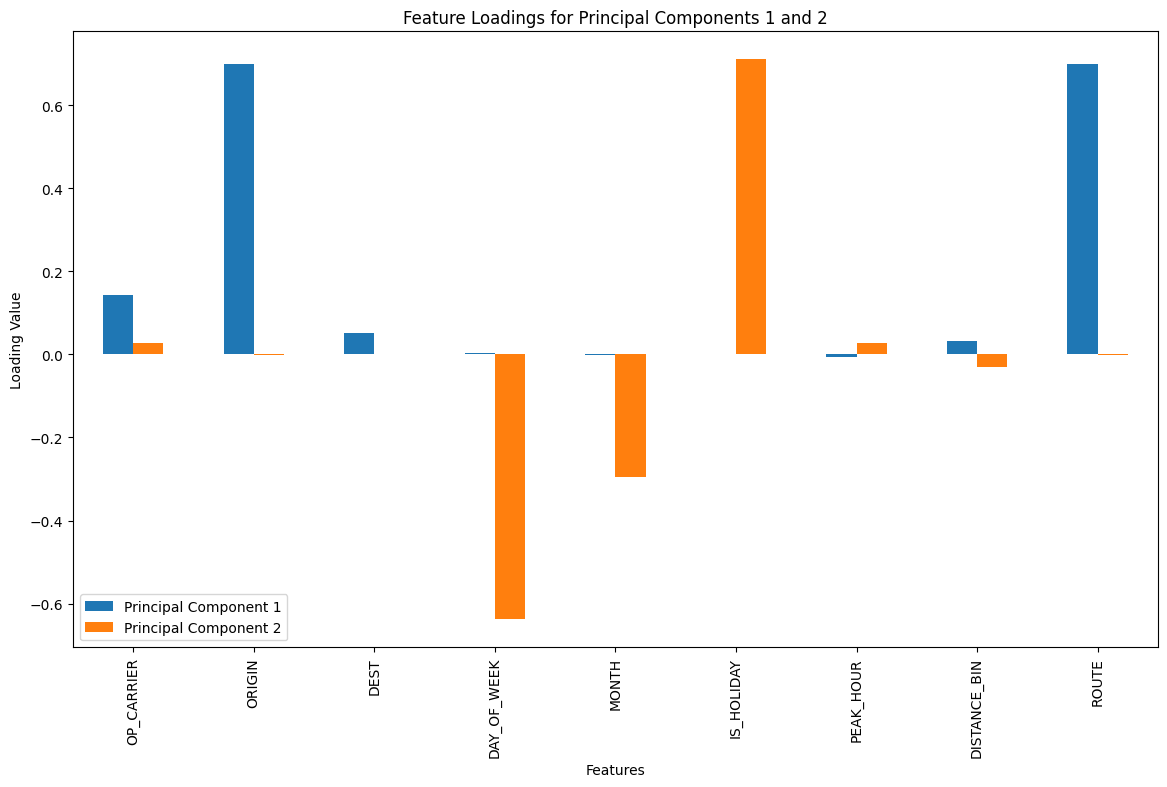

In [18]:
# Principal Component Analysis (PCA)
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
target_pca_components = 2  # Number of components to visualize
pca = PCA(n_components=target_pca_components)
X_pca = pca.fit_transform(X_scaled)

# Plotting PCA Results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Flight Delay Features')
plt.colorbar(label='Arrival Delay (Binary)')
plt.show()

# Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio by Principal Components: {explained_variance}")

# Interpreting Principal Components
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(target_pca_components)], index=X.columns)
print("\nPrincipal Component Loadings:")
print(loadings)

# Plotting Loadings for Principal Component 1 and 2
plt.figure(figsize=(12, 6))
loadings[['PC1', 'PC2']].plot(kind='bar', figsize=(14, 8))
plt.title('Feature Loadings for Principal Components 1 and 2')
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.legend(['Principal Component 1', 'Principal Component 2'])
plt.xticks(rotation=90)
plt.show()


# Seleccion de caracteristicas


RFE Feature Ranking:
         Feature  Ranking
0    OP_CARRIER        1
1        ORIGIN        1
3   DAY_OF_WEEK        1
5    IS_HOLIDAY        1
6     PEAK_HOUR        1
4         MONTH        2
2          DEST        3
7  DISTANCE_BIN        4
8         ROUTE        5


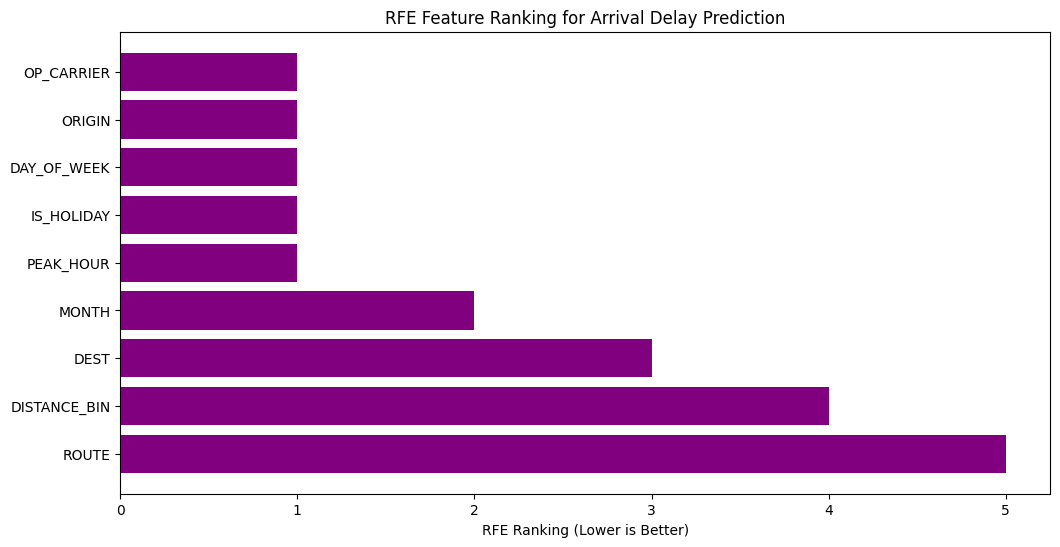

In [19]:
# Recursive Feature Elimination (RFE)
# Using Logistic Regression for RFE
model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model, n_features_to_select=5)  # Select the top 5 features
rfe.fit(X_scaled, y)

# Creating DataFrame to display RFE results
rfe_df = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
rfe_df = rfe_df.sort_values(by='Ranking')

print("\nRFE Feature Ranking:\n", rfe_df)

# Plotting RFE Feature Ranking
plt.figure(figsize=(12, 6))
plt.barh(rfe_df['Feature'], rfe_df['Ranking'], color='purple')
plt.xlabel('RFE Ranking (Lower is Better)')
plt.title('RFE Feature Ranking for Arrival Delay Prediction')
plt.gca().invert_yaxis()
plt.show()

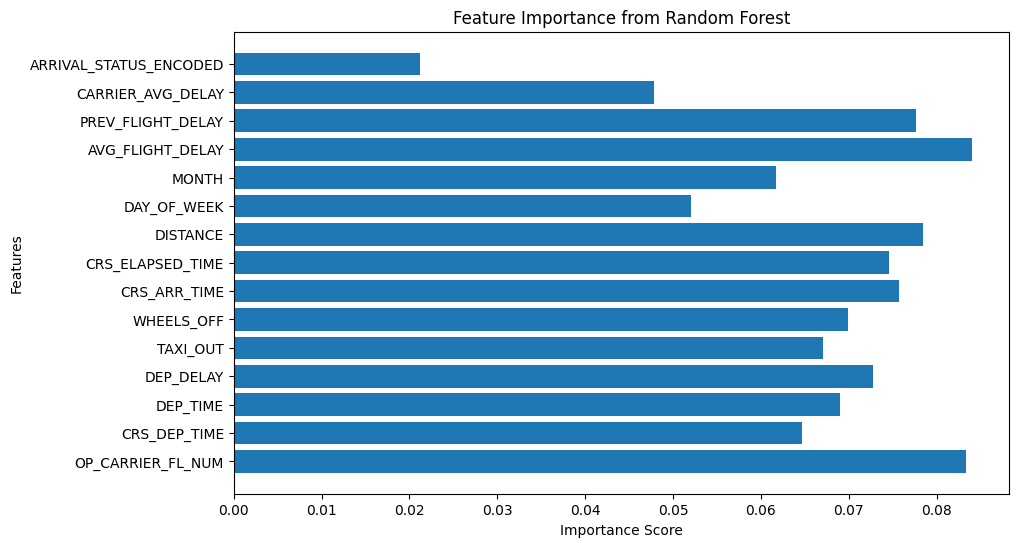

Features ranked by importance: AVG_FLIGHT_DELAY          0.084025
OP_CARRIER_FL_NUM         0.083305
DISTANCE                  0.078406
PREV_FLIGHT_DELAY         0.077678
CRS_ARR_TIME              0.075779
CRS_ELAPSED_TIME          0.074615
DEP_DELAY                 0.072814
WHEELS_OFF                0.069933
DEP_TIME                  0.068966
TAXI_OUT                  0.067030
CRS_DEP_TIME              0.064693
MONTH                     0.061720
DAY_OF_WEEK               0.052036
CARRIER_AVG_DELAY         0.047818
ARRIVAL_STATUS_ENCODED    0.021183
dtype: float64


In [20]:

X = sample_df.select_dtypes(include=[float, int]).drop(columns=['ARR_DELAY','IS_HOLIDAY','PEAK_HOUR'])
y = sample_df['ARR_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.show()

feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Features ranked by importance:", feature_importance)

# Modelos de regresion (Contra data de entrenamiento)

Aparte del que ya se mostro anteriormente de regresion lineal aqui se probaran otros modelos

In [24]:
label_encoder = LabelEncoder()
for feature in categorical_features:
    encoded_df[feature] = label_encoder.fit_transform(encoded_df[feature].astype(str))

# Creating the multi-class target: Early, On Time, Delay
def classify_arrival_status(arr_delay):
    if arr_delay < -15:
        return 'Early'
    elif arr_delay > 15:
        return 'Delay'
    else:
        return 'On Time'

encoded_df['ARRIVAL_STATUS'] = encoded_df['ARR_DELAY'].apply(classify_arrival_status)

# Encoding the target variable
encoded_df['ARRIVAL_STATUS_ENCODED'] = label_encoder.fit_transform(encoded_df['ARRIVAL_STATUS'])

Decision Tree Regression

In [87]:
# Selecting features and target
sample_encoded_df = encoded_df.sample(frac=0.01, random_state=42)
X = sample_encoded_df.drop(columns=['ROUTE','ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target for classification (Early, On Time, Delay)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity) calculation
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.6474276784002769
Sensibilidad (Recall) for class 'Delay': 0.7596787479406919
Sensibilidad (Recall) for class 'Early': 0.4198941798941799
Sensibilidad (Recall) for class 'On Time': 0.7713990470176244
Especificidad (Specificity) for class 'Delay': 0.9434609826589595
Especificidad (Specificity) for class 'Early': 0.8685072951739619
Especificidad (Specificity) for class 'On Time': 0.612879657655777
\Confusion Matrix:
[[ 3689    89  1078]
 [  110  1984  2631]
 [ 1142  2840 13437]]


Random Forest Classifier

In [88]:
X = encoded_df.drop(columns=['ROUTE','ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = encoded_df['ARRIVAL_STATUS_ENCODED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity) calculation
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.7462186354542611
Sensibilidad (Recall) for class 'Delay': 0.7919629835974241
Sensibilidad (Recall) for class 'Early': 0.4344876681077638
Sensibilidad (Recall) for class 'On Time': 0.921024071786217
Especificidad (Specificity) for class 'Delay': 0.9839690494189306
Especificidad (Specificity) for class 'Early': 0.9532095951529547
Especificidad (Specificity) for class 'On Time': 0.6173231045272893
\Confusion Matrix:
[[ 386649    2379   99188]
 [    197  208737  271487]
 [  35260  101476 1594627]]


In [89]:
 RfcModel = model

Support Vector Regression (SVR)

In [74]:
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='rbf', random_state=42)  # You can change the kernel type as needed ('linear', 'poly', 'sigmoid')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity) calculation
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)


F1-score (macro): 0.44926381602506793
Sensibilidad (Recall) for class 'Delay': 0.36202635914332787
Sensibilidad (Recall) for class 'Early': 0.0
Sensibilidad (Recall) for class 'On Time': 0.9997703656926344
Especificidad (Specificity) for class 'Delay': 0.9998193641618497
Especificidad (Specificity) for class 'Early': 1.0
Especificidad (Specificity) for class 'On Time': 0.18348815363740736
\Confusion Matrix:
[[ 1758     0  3098]
 [    0     0  4725]
 [    4     0 17415]]


Gaussnian Nave Bayes

In [75]:
X = encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Naive Bayes classifier
model = GaussianNB()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate Metrics

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.6348788517394307
Sensibilidad (Recall) for class 'Delay': 0.7888455110033264
Sensibilidad (Recall) for class 'Early': 0.24570949229946235
Sensibilidad (Recall) for class 'On Time': 0.8505241246347531
Especificidad (Specificity) for class 'Delay': 0.9568226372918874
Especificidad (Specificity) for class 'Early': 0.9190283382569397
Especificidad (Specificity) for class 'On Time': 0.5364197320564876
\Confusion Matrix:
[[ 385127    8794   94295]
 [   7631  118044  354746]
 [  87868  170929 1472566]]


Knn

In [76]:
# Prepare the features and target
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

param_grid = {'n_neighbors': range(1, 21)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best number of neighbors:", grid.best_params_['n_neighbors'])

# Train a k-Nearest Neighbors classifier
model = KNeighborsClassifier(n_neighbors=11)  # Using k=5, can be tuned for better results
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate Metrics

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)

Best number of neighbors: 20
F1-score (macro): 0.5295387067794974
Sensibilidad (Recall) for class 'Delay': 0.4497528830313015
Sensibilidad (Recall) for class 'Early': 0.10941798941798941
Sensibilidad (Recall) for class 'On Time': 0.9474711521901372
Especificidad (Specificity) for class 'Delay': 0.9938583815028902
Especificidad (Specificity) for class 'Early': 0.9608080808080808
Especificidad (Specificity) for class 'On Time': 0.29172320217096337
\Confusion Matrix:
[[ 2184    85  2587]
 [    9   517  4199]
 [  127   788 16504]]


Gradient Descent

In [77]:

# Assume sample_encoded_df is the DataFrame that contains all encoded and cleaned data
# Prepare the features and target
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Stochastic Gradient Descent classifier
model = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000, tol=1e-3)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate Metrics

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)


F1-score (macro): 0.6400606075268389
Sensibilidad (Recall) for class 'Delay': 0.774505766062603
Sensibilidad (Recall) for class 'Early': 0.15407407407407409
Sensibilidad (Recall) for class 'On Time': 0.9474137436132958
Especificidad (Specificity) for class 'Delay': 0.9788656069364162
Especificidad (Specificity) for class 'Early': 0.9787205387205388
Especificidad (Specificity) for class 'On Time': 0.47124517273771005
\Confusion Matrix:
[[ 3761    22  1073]
 [    4   728  3993]
 [  464   452 16503]]


Stacking Classifier

In [79]:
# Assume sample_encoded_df is the DataFrame that contains all encoded and cleaned data
# Prepare the features and target
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train individual base classifiers
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svc_clf = SVC(probability=True, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Create a stacking classifier
estimators = [
    ('rf', rf_clf),
    ('svc', svc_clf),
    ('gb', gb_clf),
    ('knn', knn_clf)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_clf.predict(X_test)

# Evaluate Metrics

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(np.unique(y_train)):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(np.unique(y_train))):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{np.unique(y_train)[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)


F1-score (macro): 0.7229053612583249
Sensibilidad (Recall) for class '0': 0.7839785831960461
Sensibilidad (Recall) for class '1': 0.38751322751322753
Sensibilidad (Recall) for class '2': 0.9126241460474195
Especificidad (Specificity) for class '0': 0.9810783959537572
Especificidad (Specificity) for class '1': 0.9492255892255892
Especificidad (Specificity) for class '2': 0.591378770483248
\Confusion Matrix:
[[ 3807    26  1023]
 [    2  1831  2892]
 [  417  1105 15897]]


In [80]:
StackingModel = model

Gradient Boosting Classifier

In [81]:
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate Metrics
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

sensitivity = recall_score(y_test, y_pred, average=None)
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.6837149712893852
Sensibilidad (Recall) for class 'Delay': 0.7798599670510709
Sensibilidad (Recall) for class 'Early': 0.25566137566137564
Sensibilidad (Recall) for class 'On Time': 0.9374246512428956
Especificidad (Specificity) for class 'Delay': 0.9791365606936416
Especificidad (Specificity) for class 'Early': 0.9706397306397306
Especificidad (Specificity) for class 'On Time': 0.5240580315207181
\Confusion Matrix:
[[ 3787    17  1052]
 [    9  1208  3508]
 [  453   637 16329]]


XGBoost Classifier

In [82]:
X = sample_encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = sample_encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train an XGBoost Classifier
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate Metrics
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

sensitivity = recall_score(y_test, y_pred, average=None)
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.6626560554326754
Sensibilidad (Recall) for class 'Delay': 0.7769769357495881
Sensibilidad (Recall) for class 'Early': 0.20084656084656086
Sensibilidad (Recall) for class 'On Time': 0.9451174005396407
Especificidad (Specificity) for class 'Delay': 0.9799945809248555
Especificidad (Specificity) for class 'Early': 0.9761616161616161
Especificidad (Specificity) for class 'On Time': 0.49472915144556934
\Confusion Matrix:
[[ 3773    12  1071]
 [    6   949  3770]
 [  437   519 16463]]


Linear Discriminant Analisys

In [83]:
# Prepare the data
X = encoded_df.drop(columns=['ARR_DELAY', 'FL_DATE', 'ARRIVAL_STATUS', 'ARRIVAL_STATUS_ENCODED'])  # Features
y = encoded_df['ARRIVAL_STATUS_ENCODED']  # Target (multi-class: Early, On Time, Delay)

# Standardize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train an LDA classifier
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate Metrics

# (i) F1-score (macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"F1-score (macro): {f1_macro}")

# (ii) Sensibilidad (Recall) for each class
sensitivity = recall_score(y_test, y_pred, average=None)  # Recall for each class
for idx, label in enumerate(label_encoder.classes_):
    print(f"Sensibilidad (Recall) for class '{label}': {sensitivity[idx]}")

# (iii) Especificidad (Specificity)
conf_matrix = confusion_matrix(y_test, y_pred)
specificity_per_class = []
for i in range(len(label_encoder.classes_)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)
    print(f"Especificidad (Specificity) for class '{label_encoder.classes_[i]}': {specificity}")

# Optional: Detailed classification report
print("\Confusion Matrix:")
print(conf_matrix)

F1-score (macro): 0.5496953527900462
Sensibilidad (Recall) for class 'Delay': 0.46692652432529863
Sensibilidad (Recall) for class 'Early': 0.1232564771315159
Sensibilidad (Recall) for class 'On Time': 0.9649310976381036
Especificidad (Specificity) for class 'Delay': 0.99846820485183
Especificidad (Specificity) for class 'Early': 0.9700506267179496
Especificidad (Specificity) for class 'On Time': 0.3059164578681178
\Confusion Matrix:
[[ 227961    9097  251158]
 [     49   59215  421157]
 [   3339   57378 1670646]]


Modelos:
- *DecisionTreeClassifier
- RandomForestClassifier
- *SVC
- *Bayesian
- *kNN
- Gradient Descent
- Stacking Classifier
- Gradient Boosting Classifier
- XGBoost Classifier
- Linear Discriminant Analisys

# Modelos de regresion (Contra data de prueba)

Decision Tree Regression

In [101]:
df_test = pd.read_csv('test_airlines_delay_challenge.csv')
#df_test = pd.read_csv('test_housing_data_italy.csv')
df_test.head()
# 1. Extract Day of the Week from FL_DATE
df_test['FL_DATE'] = pd.to_datetime(df_test['FL_DATE'])
df_test['DAY_OF_WEEK'] = df_test['FL_DATE'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# 2. Extract Month from FL_DATE
df_test['MONTH'] = df_test['FL_DATE'].dt.month

# 3. Holiday Indicator
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_test['FL_DATE'].min(), end=df_test['FL_DATE'].max())
df_test['IS_HOLIDAY'] = df_test['FL_DATE'].isin(holidays).astype(int)

# 4. Peak vs. Off-Peak Hours
# Assuming peak hours are 6 AM - 10 AM and 4 PM - 8 PM
def is_peak_hour(dep_time):
    hour = int(dep_time // 100)  # Extract hour from CRS_DEP_TIME (e.g., 1330 -> 13)
    return 1 if (6 <= hour <= 10) or (16 <= hour <= 20) else 0

df_test['PEAK_HOUR'] = df_test['CRS_DEP_TIME'].apply(is_peak_hour)

# 5. Average Historical Delay for Flight Number
avg_delay = df.groupby('OP_CARRIER_FL_NUM')['ARR_DELAY'].mean().reset_index()
avg_delay.columns = ['OP_CARRIER_FL_NUM', 'AVG_FLIGHT_DELAY']
df_test = df_test.merge(avg_delay, on='OP_CARRIER_FL_NUM', how='left')

# 6. Previous Flight Delay (if applicable)
df_test = df_test.sort_values(by=['OP_CARRIER_FL_NUM', 'FL_DATE'])
df_test['PREV_FLIGHT_DELAY'] = 0

# 9. Flight Distance Bins
distance_bins = [0, 300, 800, 1500, np.inf]
distance_labels = ['short_haul', 'medium_haul', 'long_haul', 'ultra_long_haul']
df_test['DISTANCE_BIN'] = pd.cut(df_test['DISTANCE'], bins=distance_bins, labels=distance_labels)

# 10. Carrier Average Delay
carrier_avg_delay = df.groupby('OP_CARRIER')['ARR_DELAY'].mean().reset_index()
carrier_avg_delay.columns = ['OP_CARRIER', 'CARRIER_AVG_DELAY']
df_test = df_test.merge(carrier_avg_delay, on='OP_CARRIER', how='left')

# 11. Flight Route Information
df_test['ROUTE'] = df_test['ORIGIN'] + '-' + df_test['DEST']

label_encoder = LabelEncoder()
for feature in categorical_features:
    df_test[feature] = label_encoder.fit_transform(df_test[feature].astype(str))

In [102]:
X = df_test.drop(columns=['ROUTE', 'FL_DATE'])
y_pred = model.predict(X)

In [107]:
X = df_test.drop(columns=['ROUTE', 'FL_DATE'])
y_pred_series = pd.Series(y_pred, name='Predictions', index=X.index)

output_df = pd.concat([X, y_pred_series], axis=1)


output_csv_path = 'X_and_y_pred.csv'
output_df.to_csv(output_csv_path, index=False)